In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Enter your path here which contains directories named ADHD_part1 and so on and so forth, the /content is path on my setup
PATH = "/content/drive/MyDrive/Archive"

In [6]:
ADHD_directories = ["ADHD_part1","ADHD_part2"]
NonADHD_directories = ["Control_part1","Control_part2"]

In [27]:
import os
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Data Loading Procedure, assigning labels and preapring a tensorflow dataset

In [8]:
def normalize(matrix):
  means = np.mean(matrix,axis=0)
  var = np.var(matrix,axis=0)
  for row in range(matrix.shape[0]):
    matrix[row] = (matrix[row]-means)/var
  return matrix

In [9]:
#this takes 100 most important vectors according to pca, this value could be increased but corresponding change should be made in tf.keras.layer.Input
def pca_for_feature_extraction(matrix):
  eigen_values, eigen_vectors = tf.linalg.eigh(tf.tensordot(tf.transpose(matrix), matrix, axes=1))
  m = tf.tensordot(tf.transpose(eigen_vectors), tf.transpose(matrix), axes=1)
  m = np.transpose(m)
  m = m[:,:10]
  an_empty_array= np.zeros(shape = (50000,10))
  for i in range(m.shape[0]):
    for j in range(m.shape[1]):
      an_empty_array[i][j] = m[i][j]
  return an_empty_array

In [10]:

labels = []
eeg_data = []
#Iterating all ADHD containing file
for directory in ADHD_directories:
  for mat_file in os.listdir(os.path.join(PATH,directory)):
    #loading the file
    loaded_file = scipy.io.loadmat(os.path.join(PATH,directory,mat_file))
    #getting data from the loaded file, mat_file[:-4] gives name of file without .mat
    per_person_data = loaded_file[mat_file[:-4]]
    per_person_data = normalize(np.array(per_person_data,dtype=float))
    feature_extracted_per_person_data = pca_for_feature_extraction(per_person_data)
    eeg_data.append(feature_extracted_per_person_data)
    #adding label 1 corresponding to adhd
    labels.append(1)
for directory in NonADHD_directories:
  for mat_file in os.listdir(os.path.join(PATH,directory)):
    loaded_file = scipy.io.loadmat(os.path.join(PATH,directory,mat_file))
    per_person_data = loaded_file[mat_file[:-4]]
    per_person_data = normalize(np.array(per_person_data,dtype=float))
    feature_extracted_per_person_data = pca_for_feature_extraction(per_person_data)
    eeg_data.append(feature_extracted_per_person_data)
    labels.append(0)
# since all files do not have one consistent data size(can be seen by print(per_person_data.shape) 
#before appending to eeg_data) used ragged contant
tensors_data = tf.data.Dataset.from_tensor_slices(np.array(eeg_data))
tensors_labels = tf.data.Dataset.from_tensor_slices(labels)
# adding two datasets together so that we have data with classes/labels
dataset = tf.data.Dataset.zip((tensors_data,tensors_labels))



In [11]:
len(dataset)

121

In [12]:
import tensorflow_datasets as tfds
df = tfds.as_dataframe(tensors_data)



In [13]:
df.size

121

In [14]:
dataset

<ZipDataset element_spec=(TensorSpec(shape=(50000, 10), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [15]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
  
    return train_ds, val_ds, test_ds

In [16]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset,len(dataset))
print("Total number of people involved in dataset ",len(dataset))
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

Total number of people involved in dataset  121


In [17]:
#tf.keras.layers.Input(shape=(100,19)) has 100 in it because we have taken 50 most important features from pca   
def create_model():
  keras_model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(50000,10)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1000),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(500),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(50),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(2),
      tf.keras.layers.Activation(tf.nn.softmax),
])
  return keras_model

In [18]:
model = create_model()

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 dense (Dense)               (None, 1000)              500001000 
                                                                 
 activation (Activation)     (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 activation_2 (Activation)   (None, 100)               0

#Model.fit takes up to one hour to run 150 epochs.

In [21]:

history = model.fit(
    train_ds,    
    batch_size=32,
    epochs=150,
    shuffle=True,
    validation_data = val_ds,verbose='auto'
)


Epoch 1/150
3/3 [==============================] - 18s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/150
3/3 [==============================] - 12s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/150
3/3 [==============================] - 11s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/150
3/3 [==============================] - 12s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/150
3/3 [==============================] - 12s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 6/150
3/3 [==============================] - 12s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 7/150
3/3 [==============================] - 12s 4s/step - loss: 0.6931 - bi

In [22]:
print(model.predict(test_ds))

1/1 [==============================] - 2s 2s/step
[[0.5000009  0.49999908]
 [0.5000031  0.49999696]
 [0.50000405 0.499996  ]
 [0.49999794 0.5000021 ]
 [0.4999987  0.5000013 ]
 [0.5000029  0.49999714]
 [0.49999765 0.5000024 ]
 [0.5000017  0.49999824]
 [0.5000033  0.49999675]
 [0.50000644 0.49999353]
 [0.5000015  0.49999848]
 [0.5000026  0.49999735]
 [0.49999973 0.5000003 ]
 [0.5000047  0.4999953 ]
 [0.5000036  0.4999964 ]
 [0.5000034  0.49999666]
 [0.50000286 0.4999972 ]
 [0.5000015  0.49999857]
 [0.5000025  0.49999747]]


In [28]:
def print_accuracy(ds):
  predictions = model.predict(ds)
  predicted_labels = np.argmax(predictions, axis=1)
  true_values = np.concatenate([y for x, y in ds], axis=0)
  count = 0
  for i in range(len(predicted_labels)):
    if predicted_labels[i] == true_values[i]:
      count = count + 1
  print("The accuracy for given dataset is: ", count/len(predicted_labels)*100)
    

In [29]:
print_accuracy(test_ds)

1/1 [==============================] - 1s 888ms/step
The accuracy for given dataset is:  63.1578947368421


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

1/1 [==============================] - 1s 925ms/step
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1]


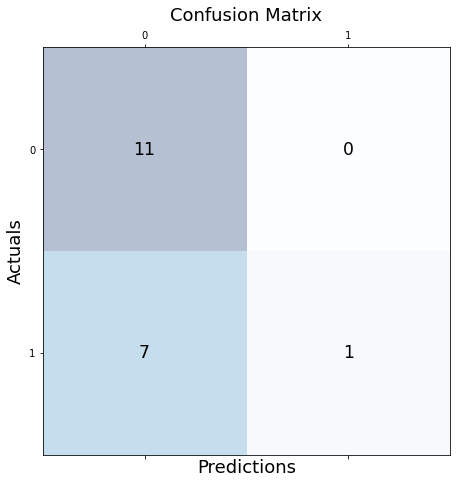

In [31]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
true_values = np.concatenate([y for x, y in test_ds], axis=0)
print(true_values)
cm =confusion_matrix(true_values,predicted_labels,labels=[0, 1])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()